<html> <img src="metro-logo.png"> </html>

In [1]:
import requests
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim
import folium 
import matplotlib.cm as cm
import matplotlib.colors as colors
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
import glob

In [2]:
CLIENT_ID = 'BCEL5IU2P4LQMQ0KFSH1AB5RHROEEXUAYV4R1WGJ3TQ20PH5' # your Foursquare ID
CLIENT_SECRET = 'ETP1ERKYJYMHB0M1QKYUZJYYF0PAQ103XOFSTKYAXTNZLYGM' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

CLIENT_ID2 ="GWSLO0VOL0BJFGZZPR3ZL0T1LRKZIWQMLA4JKSYX4J4Z1ZVT"
CLIENT_SECRET2 ="XSBRAYMU531RNS0V1GIZRFZIO05CEKGINJZEJMU3F1P52LAW"

CLIENT_ID_F ="OP1QZOPD5U0H241CZDV3EKBG4A25HS1K1OCG1LKNIIVK1Q51"
CLIENT_SECRET_F ="NKOZZ0V2CJVIWBQA1PNFKRZM231YFIZVJ133Q5DS4KL2YV1Y"

CLIENT_ID_N ="W4YAX2GW0SK4MMIWCRPACKP5RHYHCN231WQDJP0QKUC0HPDP"
CLIENT_SECRET_N ="RQEKPOJVBI3H2MRNG4T2SJLC1BOHNMEITZZWOB2H32UG0CTH"

## Load Dubai Metro Stations Dataset

In [3]:
metro_stations_df = pd.read_csv('DubaiMetro_Stations.csv',names=['station','line_name','longtude','latitude'],skiprows=1)
metro_stations_df.drop("line_name",axis=1,inplace=True)
metro_stations_df.drop_duplicates(inplace=True)
metro_stations_df.head()

,station,longtude,latitude
0,World Trade Centre Metro Station,55.285061,25.224829
1,Emirates Towers Metro Station,55.279821,25.217214
2,Financial Centre Metro Station,55.275587,25.211030
3,Burj Khalifa/ Dubai Mall Metro Station,55.269518,25.201401
4,Business Bay Metro Station,55.260419,25.191275


In [258]:
metro_stations_df

,station,longtude,latitude
0,World Trade Centre Metro Station,55.285061,25.224829
1,Emirates Towers Metro Station,55.279821,25.217214
2,Financial Centre Metro Station,55.275587,25.211030
3,Burj Khalifa/ Dubai Mall Metro Station,55.269518,25.201401
4,Business Bay Metro Station,55.260419,25.191275
5,Noor Bank Metro Station,55.228509,25.155727
6,First Abu Dhabi Bank Metro Station,55.207898,25.126721
7,Mall of the Emirates Metro Station,55.200443,25.121231
8,Sharaf DG Metro Station,55.190931,25.114809
9,Dubai Internet City Metro Station,55.173781,25.102095


In [4]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

## Venues Around Metro Stations

In [9]:
metro_venues_df = pd.DataFrame(columns=['station','venue_id','venue_name', 'categories', 'lat', 'lng'])

LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius


for lab , row in metro_stations_df.iterrows():
    neighborhood_latitude = row['latitude']
    neighborhood_longitude = row['longtude']
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
    results = requests.get(url).json()
    try:
        if results['response']['totalResults'] >0 :
            venues = results['response']['groups'][0]['items']

            nearby_venues = json_normalize(venues) # flatten JSON
            nearby_venues['station']=row['station']
            print(row['station'])

            # filter columns
            filtered_columns =['station','venue.id','venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
            nearby_venues =nearby_venues.loc[:, filtered_columns]

            # filter the category for each row
            nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

            # clean columns
            nearby_venues.columns = ['station','venue_id','venue_name', 'categories', 'lat', 'lng']

            nearby_venues
            metro_venues_df = pd.concat([metro_venues_df,nearby_venues])
    except:
        print('An error occurred.')


World Trade Centre Metro Station
Emirates Towers Metro Station
Financial Centre Metro Station
Burj Khalifa/ Dubai Mall Metro Station
Business Bay Metro Station
Noor Bank Metro Station
First Abu Dhabi Bank Metro Station
Mall of the Emirates Metro Station
Sharaf DG Metro Station
Dubai Internet City  Metro Station
Nakheel Metro Station
DAMAC Properties Metro Station
DMCC Metro Station
Nakheel Harbour & Tower Metro Station
Ibn Battuta Metro Station
Energy  Metro Station
Danube Metro Station
UAE Exchange Metro Station
Etisalat Metro Station
Al Qusais  Metro Station
Dubai Airport Free Zone Metro Station
Al Nahda Metro Station
Stadium Metro Station
Al Qiyadah Metro Station
Abu Hail Metro Station
Abu Baker Al Siddique Metro Station
Salah Al Din Metro Station
Union  (Green Line ) Metro Station
Baniyas Square Metro Station
Palm Deira Metro Station
Al Ras Metro Station
Al Ghubaiba Metro Station
Al Fahidi  Metro Station
BurJuman Metro Station
Oud Metha Metro Station
Dubai Healthcare City Metro Sta

In [17]:
metro_venues_df.drop_duplicates(['venue_id','venue_name', 'categories', 'lat', 'lng'],inplace=True,keep='first')
metro_venues_df.shape

(1525, 6)

In [18]:
metro_venues_df.head()

,station,venue_id,venue_name,categories,lat,lng
0,World Trade Centre Metro Station,5c18d290da7080002c9a6e83,Opa Dubai,Greek Restaurant,25.226190,55.284894
1,World Trade Centre Metro Station,4d3170065c2db60c9518b86c,Conrad Dubai,Hotel,25.226089,55.283571
2,World Trade Centre Metro Station,4b0587eaf964a52090a622e3,Fairmont Dubai,Hotel,25.226206,55.284714
3,World Trade Centre Metro Station,564e368a498e0884971bfdc8,Bagatelle Dubai,French Restaurant,25.226147,55.284663
4,World Trade Centre Metro Station,559581d4498e15ebe2e69b68,VII Dubai,Nightclub,25.225606,55.284104


### Categorizing Venues by a more generic category

In [22]:
category_df = pd.read_csv('DubaiVenuesCategory.csv',encoding='latin-1')

In [23]:
category_df.head()

,Category,main_category
0,Coffee Shop,Cafe
1,Shopping Mall,Mall
2,Intersection,NaN
3,Gym,Gym
4,Convenience Store,Store


In [24]:
metro_venues_df = pd.merge(metro_venues_df,category_df ,left_on='categories', right_on='Category')
metro_venues_df.drop('categories',axis=1,inplace=True)
metro_venues_df.sort_values(['lat','lng'],inplace=True)

In [25]:
metro_venues_df.head()

,station,venue_id,venue_name,lat,lng,Category,main_category
876,UAE Exchange Metro Station,5624b50d498e469eb77ddad9,Taqado Mexican Kitchen,24.980252,55.093491,Mexican Restaurant,Restaurant
857,UAE Exchange Metro Station,563095d6498ea09d5435fd44,Joga,24.980279,55.093656,Salad Place,Restaurant
1235,UAE Exchange Metro Station,536b469d498e308b4748fe87,1762,24.980698,55.093846,Deli / Bodega,Restaurant
258,UAE Exchange Metro Station,4e10288c8877ac23b655c6a4,Oregano,24.981092,55.093726,Italian Restaurant,Restaurant
338,UAE Exchange Metro Station,4e77053fe4cd32543800227e,Canteen L'Oreal ME,24.981446,55.092854,Restaurant,Restaurant


In [26]:
metro_venues_df.columns=[ 'station', 'venue_id', 'venue_name', 'lat', 'lng', 'category',
       'main_category']

In [27]:
metro_venues_df = metro_venues_df[metro_venues_df.main_category.notnull()]

In [28]:
metro_venues_df.shape

(1301, 7)

### Grouping the top business areas per metro station

In [29]:
stations_business_areas_df = pd.DataFrame(columns=['station','category', 'num_of_venues'])

In [30]:
for i, x in metro_stations_df.iterrows():
        
        station_cnt_df = metro_venues_df[metro_venues_df.station== x['station']].groupby(['station','main_category'])[['venue_name']].agg(len)
        station_cnt_df.reset_index(inplace=True)
       ## station_cnt_df.sort_values('venue_name',ascending=False,inplace=True)
        try:
            station_cnt_df = station_cnt_df[station_cnt_df.venue_name>=3]
            station_cnt_df.columns =['station','category', 'num_of_venues']
            stations_business_areas_df = pd.concat([stations_business_areas_df,station_cnt_df])
        except:
            print('Err2')
            print(x['station'])

Err2
Danube Metro Station
Err2
Union  Metro Station


In [260]:
stations_business_areas_df.shape

(119, 3)

In [32]:
stations_business_areas_df.reset_index(drop=True,inplace=True)
stations_business_areas_df.sort_values(['station','num_of_venues'],ascending=[True,False],inplace=True)
stations_business_areas_df.reset_index(drop=True,inplace=True)
stations_business_areas_df.head()

,station,category,num_of_venues
0,ADCB Metro Station,Restaurant,27
1,ADCB Metro Station,Hotel,4
2,ADCB Metro Station,Cafe,3
3,Abu Baker Al Siddique Metro Station,Restaurant,11
4,Abu Baker Al Siddique Metro Station,Hotel,4


### Get The number of likes for every venue

In [33]:
users_df = pd.DataFrame(columns=['id', 'firstName', 'lastName', 'gender', 'photo.prefix', 'photo.suffix',
       'venue_id'])

In [34]:
#CLIENT_ID2 ="GWSLO0VOL0BJFGZZPR3ZL0T1LRKZIWQMLA4JKSYX4J4Z1ZVT"
#CLIENT_SECRET2 ="XSBRAYMU531RNS0V1GIZRFZIO05CEKGINJZEJMU3F1P52LAW"

def get_likes_count(venue):
    venue_id = venue['venue_id']
    url = 'https://api.foursquare.com/v2/venues/{}/likes?&client_id={}&client_secret={}&v={}'.format(
    
    venue_id,
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
  )
    global users_df
    try:
        results = requests.get(url).json()
        usrs = results['response']['likes']['items']
        
        usrs2 = json_normalize(usrs) # flatten JSON
        usrs2["venue_id"] = venue_id
        #print(venue_id)
        users_df= pd.concat([ users_df,usrs2],sort=True)
        
        return results['response']['likes']['count']
    except:
        return 0

In [35]:
stations_business_venues_df = pd.merge(metro_venues_df,stations_business_areas_df,right_on=['station','category'],left_on=['station','main_category'])
stations_business_venues_df.drop('category_y',axis=1,inplace=True)
stations_business_venues_df.columns=['station','venue_id','venue_name','lat','lng','category','main_category','num_of_venues']

#### Setting num_of_likes to 0 as a default value as the get_likes_count function will be run many times as we have number of calling per day limitation

In [36]:
stations_business_venues_df['num_of_likes'] =0
#4dfe20d3aeb7ea26f9aac135
#stations_business_venues_df= stations_business_venues_df[stations_business_venues_df.venue_id.isin([ "4b222e4cf964a520394424e3","55e1ea54498e40d5c9052ff2"])]

In [38]:
stations_business_venues_df['num_of_likes'] = stations_business_venues_df.apply(get_likes_count,axis=1)
#[stations_business_venues_df['num_of_likes'] ==0]

In [39]:
stations_business_venues_df.head()#[stations_business_venues_df.num_of_likes>0]

,station,venue_id,venue_name,lat,lng,category,main_category,num_of_venues,num_of_likes
0,UAE Exchange Metro Station,5624b50d498e469eb77ddad9,Taqado Mexican Kitchen,24.980252,55.093491,Mexican Restaurant,Restaurant,5,5
1,UAE Exchange Metro Station,563095d6498ea09d5435fd44,Joga,24.980279,55.093656,Salad Place,Restaurant,5,2
2,UAE Exchange Metro Station,536b469d498e308b4748fe87,1762,24.980698,55.093846,Deli / Bodega,Restaurant,5,12
3,UAE Exchange Metro Station,4e10288c8877ac23b655c6a4,Oregano,24.981092,55.093726,Italian Restaurant,Restaurant,5,5
4,UAE Exchange Metro Station,4e77053fe4cd32543800227e,Canteen L'Oreal ME,24.981446,55.092854,Restaurant,Restaurant,5,0


In [43]:
stations_business_venues_df_2 = stations_business_venues_df[stations_business_venues_df.num_of_likes==0]
stations_business_venues_df = stations_business_venues_df[stations_business_venues_df.num_of_likes>0]

### Run the API one more time with different user for user max number of calling

In [45]:
#CLIENT_ID2 ="GWSLO0VOL0BJFGZZPR3ZL0T1LRKZIWQMLA4JKSYX4J4Z1ZVT"
#CLIENT_SECRET2 ="XSBRAYMU531RNS0V1GIZRFZIO05CEKGINJZEJMU3F1P52LAW"

def get_likes_count(venue):
    venue_id = venue['venue_id']
    url = 'https://api.foursquare.com/v2/venues/{}/likes?&client_id={}&client_secret={}&v={}'.format(
    
    venue_id,
    CLIENT_ID2, 
    CLIENT_SECRET2, 
    VERSION, 
  )
    global users_df
    try:
        results = requests.get(url).json()
        usrs = results['response']['likes']['items']
        
        usrs2 = json_normalize(usrs) # flatten JSON
        usrs2["venue_id"] = venue_id
        #print(venue_id)
        users_df= pd.concat([ users_df,usrs2],sort=True)
        
        return results['response']['likes']['count']
    except:
        return 0

In [46]:
stations_business_venues_df_2['num_of_likes'] = stations_business_venues_df_2.apply(get_likes_count,axis=1)

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [55]:
stations_business_venues_df = pd.concat([ stations_business_venues_df,stations_business_venues_df_2],sort=True)
stations_business_venues_df.drop_duplicates(inplace=True)
print(stations_business_venues_df.shape)

(1077, 9)


### Plotting venues numbers of each categories

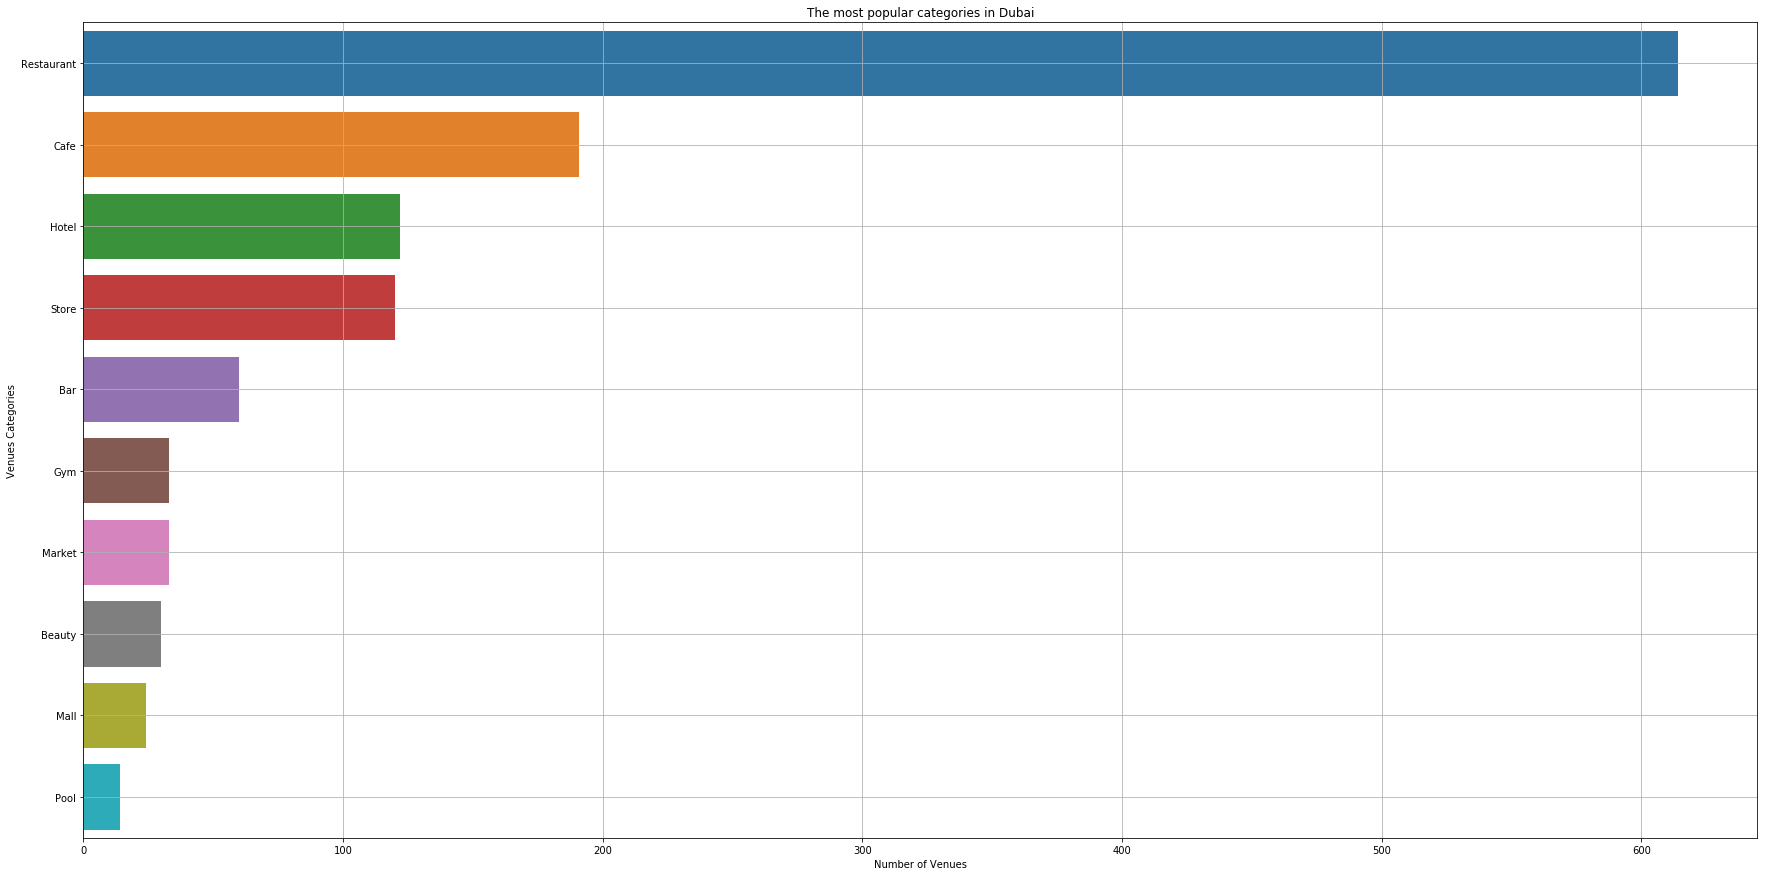

In [163]:
tot_cat_df = pd.DataFrame(metro_venues_df.main_category.value_counts().head(10))
tot_cat_df.reset_index(drop=False,inplace=True)
tot_cat_df.columns=['category','cnt']

fig = plt.figure(figsize=(30,15))
ax = sns.barplot(y=tot_cat_df.category, x= tot_cat_df.cnt)
ax.set_xlabel("Number of Venues")
ax.set_ylabel("Venues Categories")
ax.set_title("The most popular categories in Dubai")
plt.grid()
plt.show()

In [250]:
tot_cat_df

,category,cnt
0,Restaurant,614
1,Cafe,191
2,Hotel,122
3,Store,120
4,Bar,60
5,Gym,33
6,Market,33
7,Beauty,30
8,Mall,24
9,Pool,14


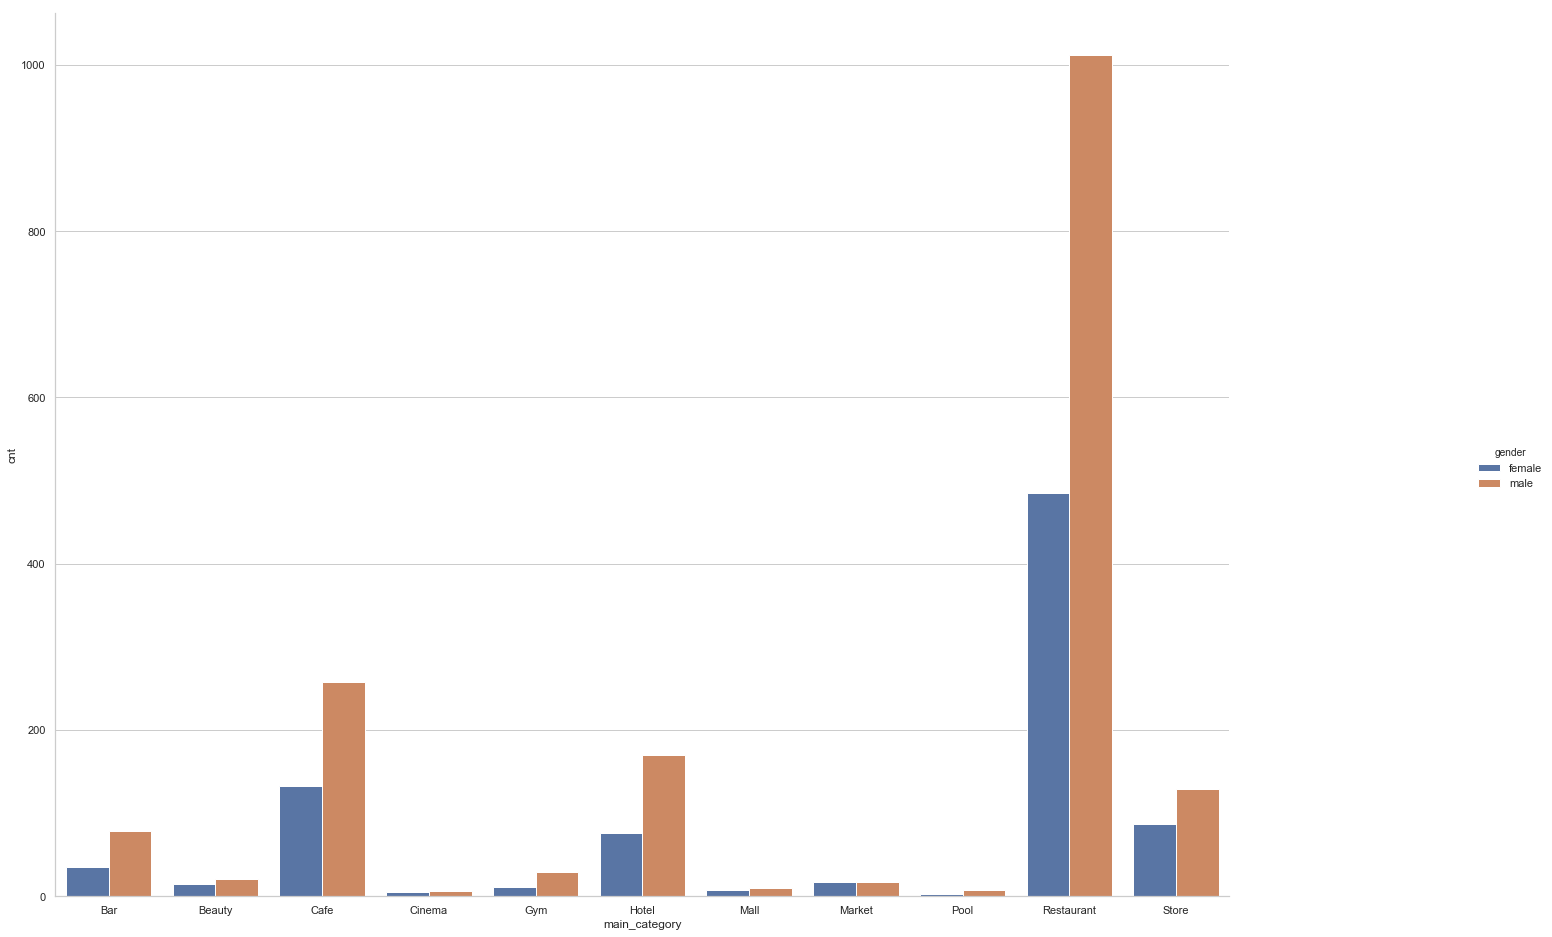

In [243]:
gender_cat_df = users_df.groupby(['main_category','gender'])[['id']].agg(len)
gender_cat_df.reset_index(inplace=True)
gender_cat_df=gender_cat_df[gender_cat_df.gender!='none'].sort_values(['main_category','gender'])
gender_cat_df.rename(columns={'id':'cnt'},inplace=True)
#fig,ax1 = plt.subplots(figsize=(15,5))
#sns.set(style="whitegrid")

ax1=sns.catplot(x="main_category", y="cnt", hue="gender", data=gender_cat_df, kind="bar")
ax1.fig.set_size_inches(25, 15)
#ax1.set_xlabel("Categories")
#ax1.set_ylabel("Number of Likes")
plt.show()

In [251]:
gender_cat_df

,main_category,gender,cnt
0,Bar,female,35
1,Bar,male,78
3,Beauty,female,15
4,Beauty,male,21
6,Cafe,female,132
7,Cafe,male,258
9,Cinema,female,5
10,Cinema,male,6
12,Gym,female,11
13,Gym,male,29


### Get the Top 10 Venues list

In [56]:
top_10_venues = stations_business_venues_df.sort_values('num_of_likes', ascending=False).head(10)

In [57]:
top_10_stations = pd.DataFrame(stations_business_venues_df.groupby('station')['num_of_likes'].sum())
top_10_stations.sort_values('num_of_likes',ascending=False,inplace=True)
top_10_stations =top_10_stations.head(10)

In [252]:
top_10_stations

,num_of_likes
station,
Mall of the Emirates Metro Station,13248
Emirates Towers Metro Station,7984
Financial Centre Metro Station,4987
World Trade Centre Metro Station,4650
Dubai Internet City Metro Station,2773
Ibn Battuta Metro Station,2729
DAMAC Properties Metro Station,2034
Dubai Healthcare City Metro Station,2024
Sharaf DG Metro Station,1978


In [253]:
top_10_venues

,category,lat,lng,main_category,num_of_likes,num_of_venues,station,venue_id,venue_name,ename
22,Shopping Mall,25.045810,55.120435,Mall,1972,4,Ibn Battuta Metro Station,4b0587f2f964a520b5a822e3,Ibn Battuta Mall (مركز ابن بطوطة),Ibn Battuta Mall
334,Multiplex,25.119131,55.201967,Cinema,1807,4,Mall of the Emirates Metro Station,4b222e4cf964a520394424e3,VOX Cinemas (فوكس سينما),VOX Cinemas
419,Middle Eastern Restaurant,25.213480,55.277597,Restaurant,1654,41,Emirates Towers Metro Station,4cbc0811bac937046896f57c,Zaroob (مطعم زاروب),Zaroob
278,American Restaurant,25.118579,55.198386,Restaurant,1620,19,Mall of the Emirates Metro Station,50b97b61e4b0c379f354969f,The Cheesecake Factory (تشيز كيك فاكتوري),The Cheesecake Factory
273,Burger Joint,25.118024,55.198738,Restaurant,1037,19,Mall of the Emirates Metro Station,4d99db96c19fb60c51e0cc65,Shake Shack (شيك شاك),Shake Shack
304,Electronics Store,25.118407,55.199809,Store,700,21,Mall of the Emirates Metro Station,5631b397498e5ab30a494ece,Apple Mall of the Emirates (متجر آبل),Apple Mall of the Emirates
458,Hotel,25.213067,55.279473,Hotel,696,4,Emirates Towers Metro Station,4d214b4e16cfb60ccb646061,"The Ritz-Carlton, Dubai International Financia...","The Ritz-Carlton, Dubai International Financia..."
270,Chinese Restaurant,25.117421,55.200229,Restaurant,689,19,Mall of the Emirates Metro Station,4c814e5f74d7b60c887a75d8,P.F. Chang's (بي إف تشانغز),P.F. Chang's
534,Hotel,25.226089,55.283571,Hotel,671,5,World Trade Centre Metro Station,4d3170065c2db60c9518b86c,Conrad Dubai,Conrad Dubai
330,Hotel,25.118931,55.197542,Hotel,670,3,Mall of the Emirates Metro Station,4b0c87bff964a520da3e23e3,Kempinski Hotel Mall of the Emirates (فندق كمب...,Kempinski Hotel Mall of the Emirates


### Plotting top business areas per metro station 

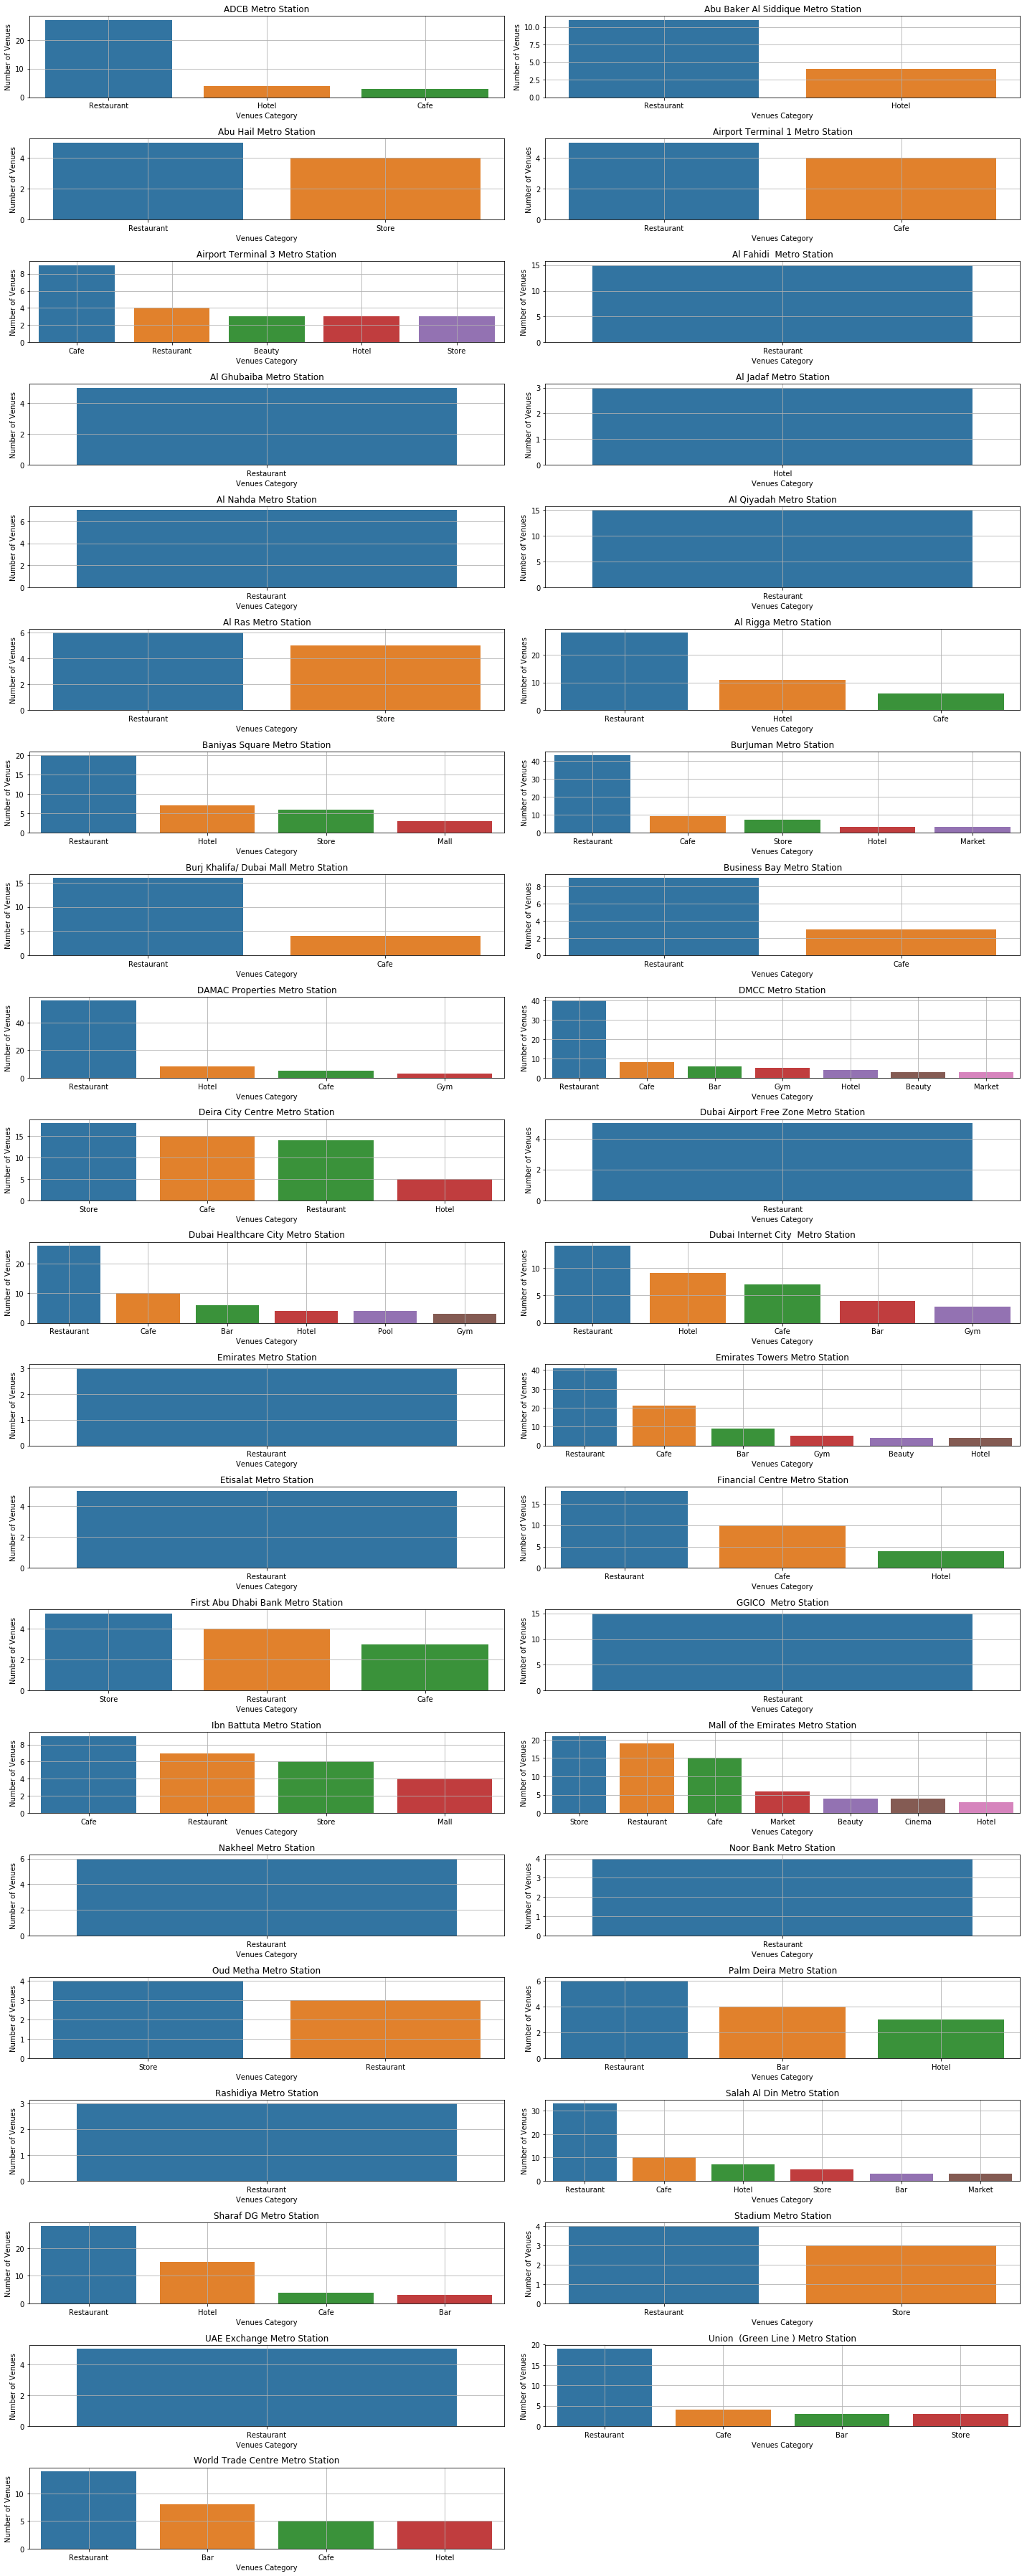

In [59]:
import math
rownum = math.ceil(stations_business_areas_df.station.unique().size/2)
fig = plt.figure(figsize=(20,50))
row =1
cnt = 1
for i in stations_business_areas_df.station.unique():
    col = (1 if cnt%2!=0 else 2)
    t = stations_business_areas_df[stations_business_areas_df.loc[:,'station'] ==i]
    ax= plt.subplot(rownum, 2, cnt)
    sns.barplot(x=t.category, y=t.num_of_venues)
    ax.set_xlabel("Venues Category")
    ax.set_ylabel("Number of Venues")
    ax.set_title( i)
    plt.grid()
    fig.tight_layout()
   
    cnt+=1
    if (col ==2):
        row+=1
plt.show()        

In [60]:
def clean_venue_name(item):
    name = item['venue_name']
    return name.split("(")[0]

In [61]:
top_10_venues["ename"] = top_10_venues.apply(clean_venue_name,axis=1)

### Plotting popular venues

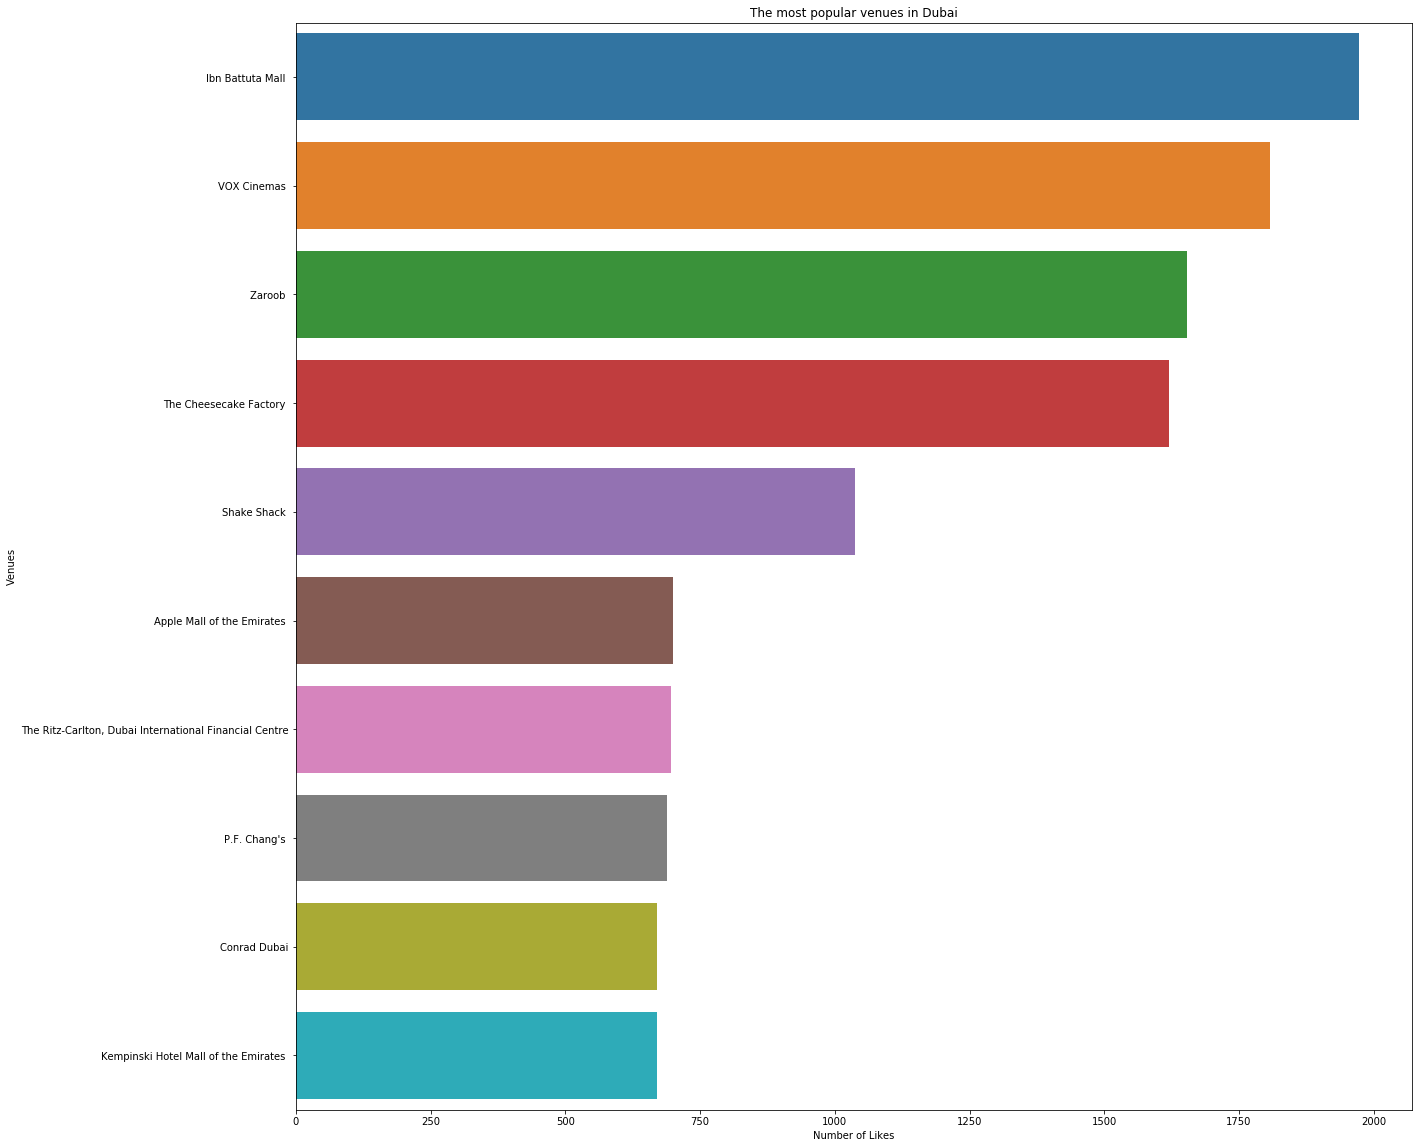

In [62]:
fig = plt.figure(figsize=(20,20))
ax = sns.barplot(y=top_10_venues.ename, x= top_10_venues.num_of_likes)
ax.set_ylabel("Venues")
ax.set_xlabel("Number of Likes")
ax.set_title("The most popular venues in Dubai")
plt.show()

# Categorizing and Pricing
In order to set prices for the advertising we need to categorize the metro station based on the number of passengers per day.
Moreover, we will need to calculate the peak hours per station as it will help in the pricing process of the electronic boards

### Load the monthly number of trips data per station

In [63]:
path = r'trips_data'
all_trips_f = glob.glob(path + "/*.csv")
li = []
for filename in all_trips_f:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

all_trips_df = pd.concat(li, axis=0, ignore_index=True)

In [64]:
all_trips_df.head()

,year,month,metro_station,trips
0,2019,Aug,Abu Baker Al Siddique Metro Station,316825
1,2019,Aug,Abu Hail Metro Station,230371
2,2019,Aug,ADCB Metro Station,489146
3,2019,Aug,Airport Terminal 1 Metro Station,231888
4,2019,Aug,Airport Terminal 3 Metro Station,144990


In [65]:
station_trip_avg_df = pd.DataFrame(all_trips_df.groupby(['metro_station'])['trips'].agg(np.mean))
station_trip_avg_df['trips'] = station_trip_avg_df.apply(lambda x:int(x['trips']),axis=1)
station_trip_avg_df['station_cat']= pd.cut(station_trip_avg_df.trips,bins=4,labels=['D','C','B','A']) 

,trips,station_cat
metro_station,,
ADCB Metro Station,527789,B
Abu Baker Al Siddique Metro Station,353043,C
Abu Hail Metro Station,254428,D
Airport Terminal 1 Metro Station,241753,D
Airport Terminal 3 Metro Station,151413,D


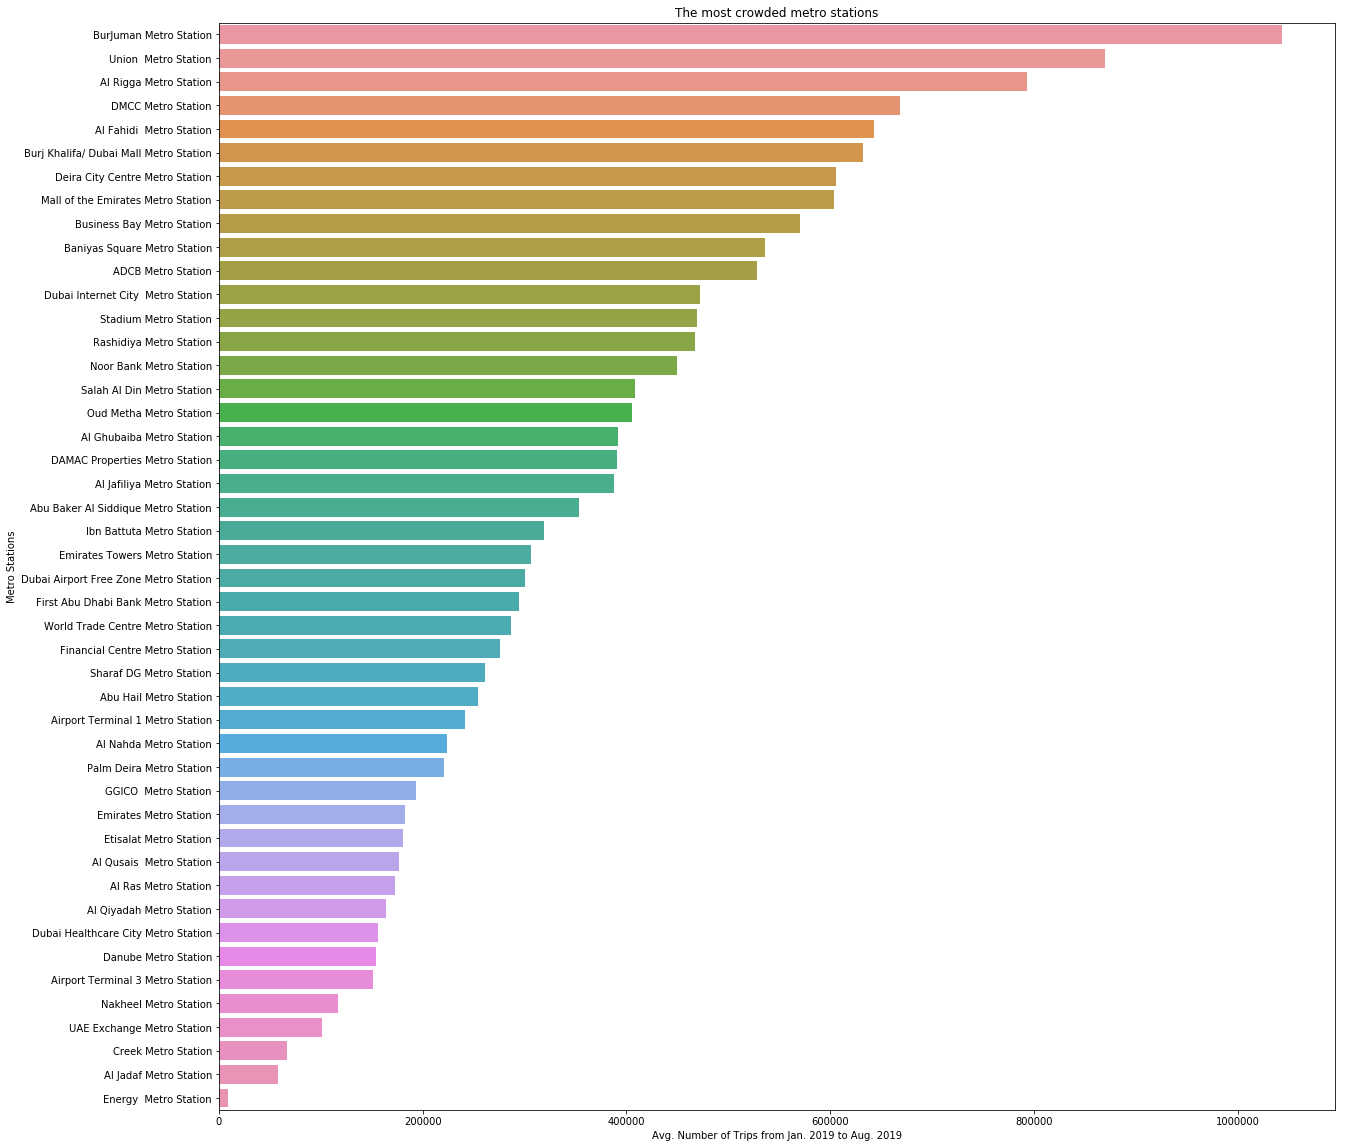

In [66]:
station_trip_plot_df = station_trip_avg_df.reset_index()
station_trip_plot_df.sort_values('trips',ascending=False,inplace=True)
fig = plt.figure(figsize=(20,20))
ax = sns.barplot(y=station_trip_plot_df.metro_station, x= station_trip_plot_df.trips)
ax.set_ylabel("Metro Stations")
ax.set_xlabel("Avg. Number of Trips from Jan. 2019 to Aug. 2019")
ax.set_title("The most crowded metro stations")
plt.show()

In [257]:
station_trip_avg_df.sort_values('station_cat',ascending=False)

,trips,station_cat
metro_station,,
Al Rigga Metro Station,792759,A
Union Metro Station,870036,A
BurJuman Metro Station,1043268,A
ADCB Metro Station,527789,B
DMCC Metro Station,668528,B
Al Fahidi Metro Station,642929,B
Business Bay Metro Station,570489,B
Burj Khalifa/ Dubai Mall Metro Station,631956,B
Mall of the Emirates Metro Station,603693,B


### Load trips dataset per hour per metro station ( 27-3-2018 Data)

In [67]:
metro_ridership_df =   pd.read_csv('metro_ridership_2018-03-27_00-00-00.csv')
metro_ridership_df = metro_ridership_df[['txn_type','txn_date','txn_time','end_location']]
metro_ridership_df.columns = ['txn_type','txn_date','txn_time','station']
metro_ridership_df.head()

/Applications/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,txn_type,txn_date,txn_time,station
0,Check in,2018-03-27,23:05:19,Burj Khalifa/ Dubai Mall Metro Station
1,Check in,2018-03-27,21:32:43,Burj Khalifa/ Dubai Mall Metro Station
2,Check in,2018-03-27,19:28:22,Burj Khalifa/ Dubai Mall Metro Station
3,Check in,2018-03-27,22:26:32,Burj Khalifa/ Dubai Mall Metro Station
4,Check in,2018-03-27,14:06:16,Burj Khalifa/ Dubai Mall Metro Station


In [68]:
metro_ridership_df['hour']= metro_ridership_df.apply(lambda x : x['txn_time'].split(':')[0],axis=1)
metro_ridership_df.hour = metro_ridership_df.hour.astype(int)

In [69]:
metro_ridership_df.sort_values(['station','hour'],inplace = True)
metro_ridership_df.head()

,txn_type,txn_date,txn_time,station,hour
58888,Check in,2018-03-27,04:57:40,ADCB Metro Station,4
100689,Check in,2018-03-27,04:57:37,ADCB Metro Station,4
441338,Check in,2018-03-27,04:57:34,ADCB Metro Station,4
445513,Check in,2018-03-27,04:57:15,ADCB Metro Station,4
453424,Check in,2018-03-27,04:56:15,ADCB Metro Station,4


In [70]:
metro_rider_cnt_df = pd.DataFrame( metro_ridership_df.groupby(['station','hour'])['hour'].agg(len))
metro_rider_cnt_df.columns=['pass_cnt']
metro_rider_cnt_df.reset_index(inplace=True)

In [71]:

metro_rider_cnt_df.head()

,station,hour,pass_cnt
0,ADCB Metro Station,4,10
1,ADCB Metro Station,5,424
2,ADCB Metro Station,6,1879
3,ADCB Metro Station,7,3584
4,ADCB Metro Station,8,3687


/Applications/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


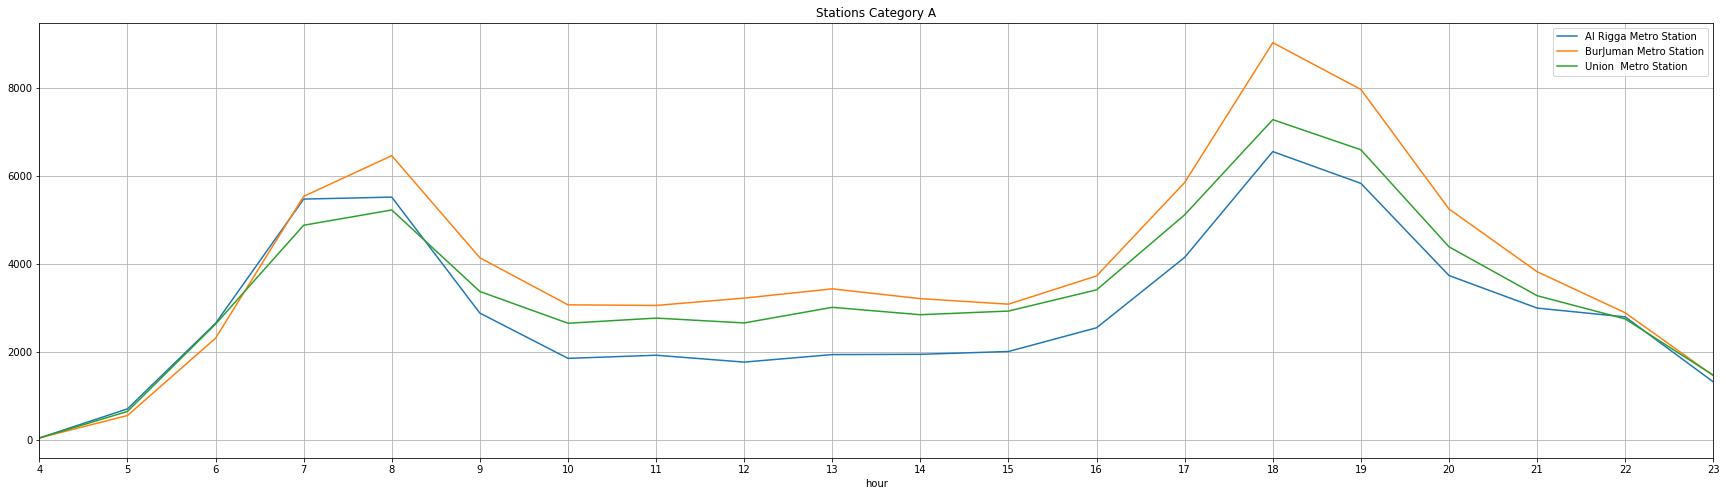

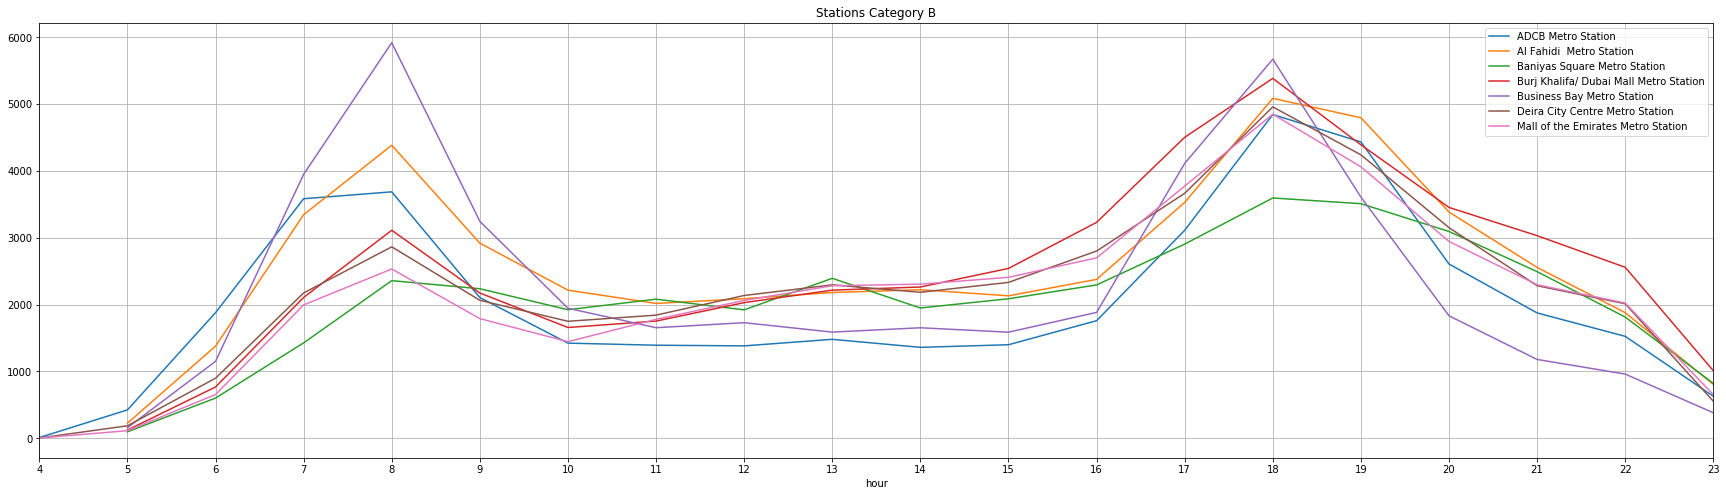

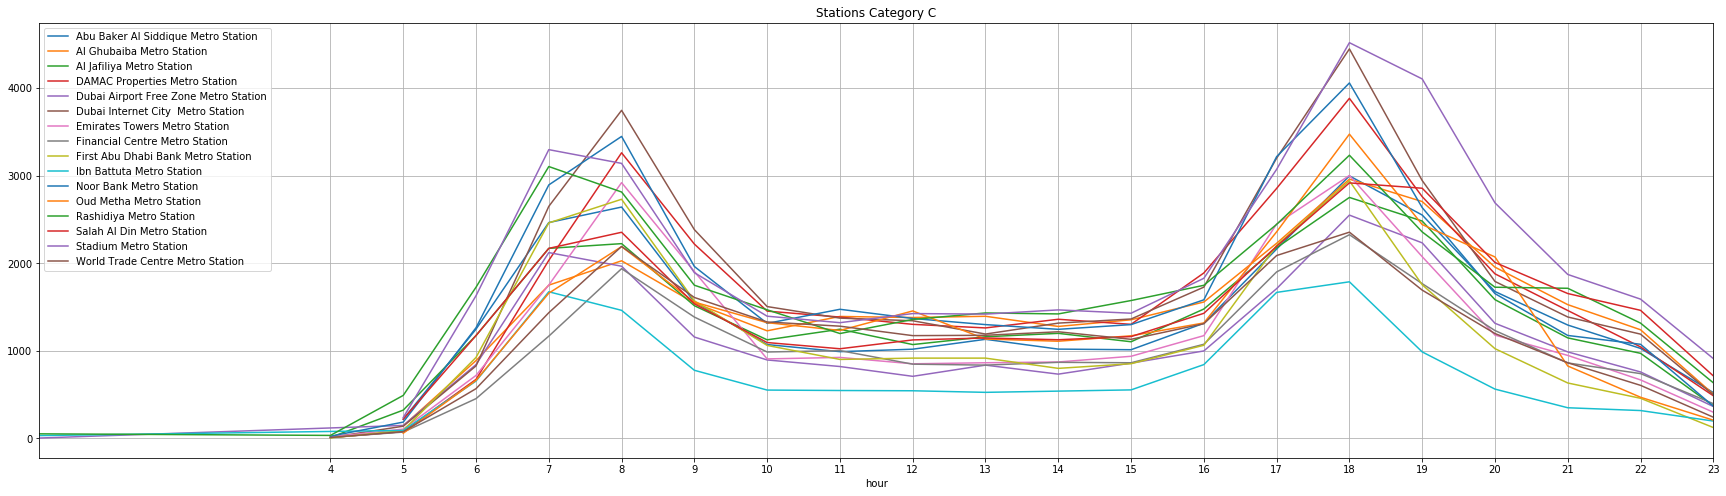

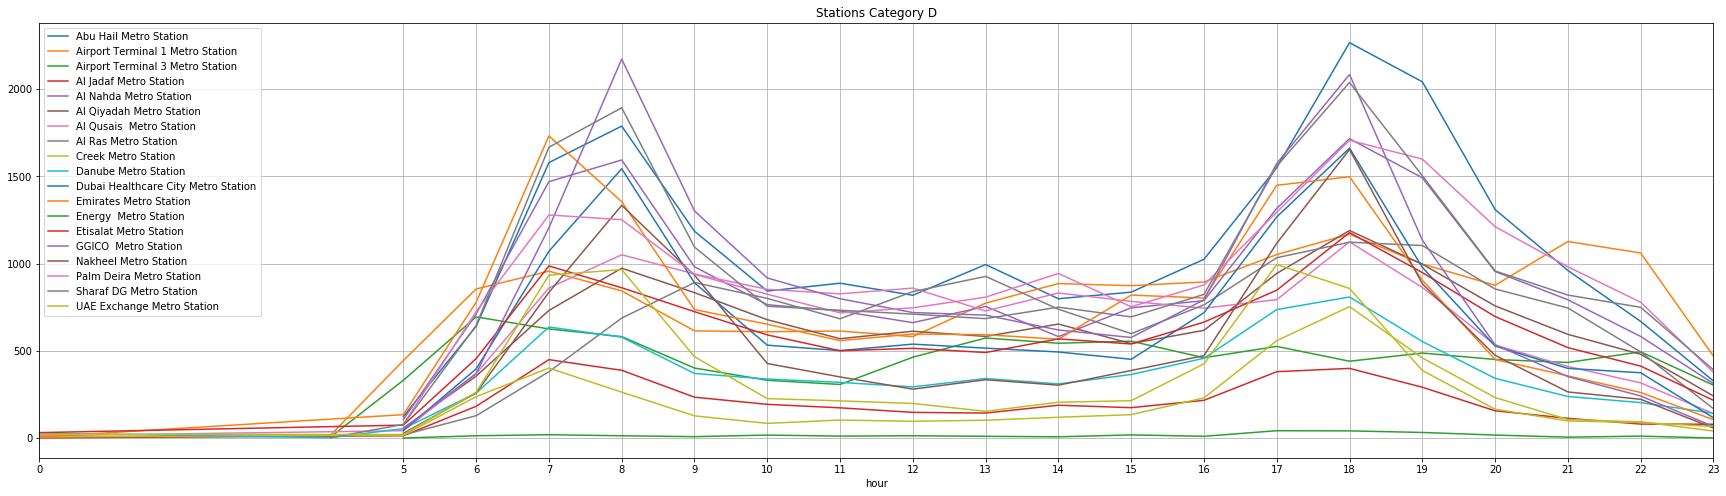

In [72]:
for cat in ['A','B','C','D']:
    fig = plt.figure(figsize=(30,8))
    stations = station_trip_avg_df[station_trip_avg_df.station_cat==cat].index
    df = metro_rider_cnt_df[metro_rider_cnt_df.station.isin (stations)]
    for i in df.station.unique():
        ax= plt.subplot(1, 1, 1)
        df2 = df[df.station==i]
        ax= df2.plot(x='hour', y='pass_cnt',ax=ax,label=i)
        ax.legend()
        ax.set_xticks(df2.hour)
        ax.grid()
        ax.set_title("Stations Category "+cat)
        
        
plt.show() 

### Plotting Total number of trips per month

In [73]:
def get_month_num(item):
    month = item['month']
    if (month == 'Jan'):
        return 1
    elif (month == 'Feb'):
        return 2
    elif (month == 'Mar'):
        return 3
    elif (month == 'Apr'):
        return 4
    elif (month == 'May'):
        return 5
    elif (month == 'Jun'):
        return 6
    elif (month == 'Jul'):
        return 7
    elif (month == 'Aug'):
        return 8
    elif (month == 'Sep'):
        return 9
    elif (month == 'Oct'):
        return 10
    elif (month == 'Nov'):
        return 11
    elif (month == 'Dec'):
        return 12

In [74]:
trips_per_month_df = pd.DataFrame(all_trips_df.groupby(['month'])['trips'].agg(sum))

In [75]:
trips_per_month_df.reset_index(inplace=True)
trips_per_month_df['month_num'] = trips_per_month_df.apply(get_month_num,axis=1)
trips_per_month_df['trips'] = trips_per_month_df.apply(lambda x:  np.round(x['trips']),axis=1)
trips_per_month_df.sort_values('month_num',inplace=True)

In [76]:
trips_per_month_df.head()

,month,trips,month_num
3,Jan,17963597,1
2,Feb,16655042,2
6,Mar,18081336,3
0,Apr,17361296,4
7,May,16255709,5


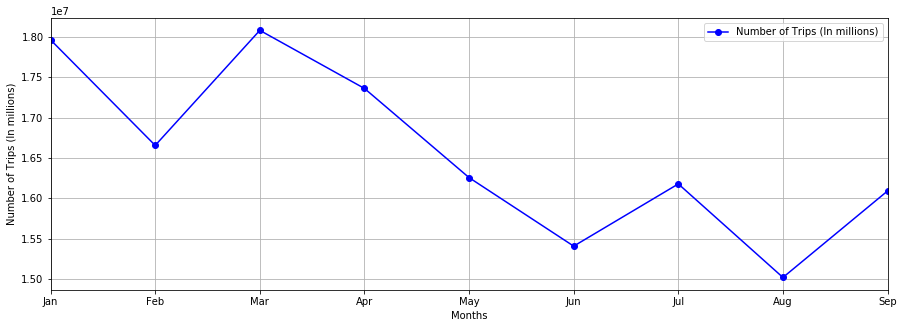

In [77]:
fig = plt.figure(figsize=(15,5))
ax= plt.subplot(1, 1, 1)
trips_per_month_df.plot(x='month_num', y='trips',marker='o',ax=ax,color='blue',label="Number of Trips (In millions)")
ax.grid()
ax.set_xticklabels(trips_per_month_df.month)
ax.set_xlabel("Months")
ax.set_ylabel("Number of Trips (In millions)")
plt.show()

### Dubai metro stations map - Per category

In [78]:
station_avg_geo_df = pd.merge(left=station_trip_avg_df , right = metro_stations_df ,how="inner" , left_index=True , right_on="station" )

In [79]:
station_avg_geo_df.trips = (station_avg_geo_df.trips/10000).astype(int)
station_avg_geo_df.station_cat =pd.Categorical(station_avg_geo_df.station_cat,categories=['A','B','C','D'])
station_avg_geo_df['cat_code'] = station_avg_geo_df.station_cat.cat.codes
station_avg_geo_df.head()

,trips,station_cat,station,longtude,latitude,cat_code
48,52,B,ADCB Metro Station,55.298196,25.244494,1
25,35,C,Abu Baker Al Siddique Metro Station,55.332983,25.270904,2
24,25,D,Abu Hail Metro Station,55.346268,25.275242,3
42,24,D,Airport Terminal 1 Metro Station,55.352474,25.248428,3
41,15,D,Airport Terminal 3 Metro Station,55.359526,25.245013,3


In [80]:
address = 'Dubai'
geolocator = Nominatim(user_agent="dubai_explorer")
#location = geolocator.geocode(address)
latitude = 25.2048
longitude = 55.2708
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11, tiles="OpenStreetMap")

for i in (['A','B','C','D']):
        station_avg_geo_df_A = station_avg_geo_df[station_avg_geo_df.station_cat==i]
        colordict = {0: 'red', 1: 'green', 2: 'orange', 3: 'blue'}
        for lat, lon, station_cat, station, trips,cat_code in zip(station_avg_geo_df_A['latitude'], station_avg_geo_df_A['longtude'], station_avg_geo_df_A['station_cat'], station_avg_geo_df_A['station'], station_avg_geo_df_A['trips'],station_avg_geo_df_A['cat_code']):
            folium.CircleMarker(
                [lat, lon],
                radius=trips*.15,

                color='b',
                #key_on = cat_code,
                #threshold_scale=[0,1,2,3],
                fill_color=colordict[cat_code],
                fill=True,
                fill_opacity=1
                ).add_to(map_clusters)

        for lat, lon, station_cat, station, trips in zip(station_avg_geo_df_A['latitude'], station_avg_geo_df_A['longtude'], station_avg_geo_df_A['station_cat'], station_avg_geo_df_A['station'], station_avg_geo_df_A['trips']):
            folium.Marker(
                [lat, lon],
               # radius=trips*.1,
                popup = ('Station : ' + station + '<br>'
                         'Category: ' + station_cat
                        ),
                ).add_to(map_clusters) 
map_clusters


<table id="myTable"style="float: left;" border="0">
  <tr>
    
    <td style="text-align: center;"><span style="color: red;height: 25px;
  width: 25px;
  background-color: Red;
  border-radius: 50%;
  display: inline-block;"></span></td>
  <td>Category A </td>
  </tr>
  <tr>
   
    <td style="text-align: center;"><span style="height: 20px;
  width: 20px;
  background-color: Green;
  border-radius: 50%;
  display: inline-block;"></span></td>
   <td>Category B</td>
  </tr>
  <tr>
    
    <td style="text-align: center;"><span style="height: 15px;
  width: 15px;
  background-color: Orange;
  border-radius: 50%;
  display: inline-block;"></span></td>
  <td>Category C</td>
  </tr>
  <tr>
    
    <td style="text-align: center;"><span style="height: 10px;
  width: 10px;
  background-color: Blue;
  border-radius: 50%;
  display: inline-block;"></span></td>
  <td>Category D</td>
  </tr>
</table>


### Create and clean a data frame of All Users likes

In [82]:
users_df = users_df[['firstName', 'gender', 'id', 'lastName',
       'venue_id']]
users_df.drop_duplicates(inplace=True)
users_df.reset_index(drop=True,inplace=True)
users_df = pd.merge(left=users_df, right=stations_business_venues_df,left_on="venue_id",right_on="venue_id", how="inner")
users_df = users_df[['firstName', 'gender', 'id', 'lastName',
       'venue_id','venue_name','category','main_category','station']]

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [84]:
users_df.head()

,firstName,gender,id,lastName,venue_id,venue_name,category,main_category,station
0,Dmitry,male,2944432,Borisov,5624b50d498e469eb77ddad9,Taqado Mexican Kitchen,Mexican Restaurant,Restaurant,UAE Exchange Metro Station
1,Gilbert,male,61897359,Eid,5624b50d498e469eb77ddad9,Taqado Mexican Kitchen,Mexican Restaurant,Restaurant,UAE Exchange Metro Station
2,Abeer,female,20329813,Hakim,5624b50d498e469eb77ddad9,Taqado Mexican Kitchen,Mexican Restaurant,Restaurant,UAE Exchange Metro Station
3,Roy,male,54367317,Gawthorpe,563095d6498ea09d5435fd44,Joga,Salad Place,Restaurant,UAE Exchange Metro Station
4,Miki,female,37064202,Hirasawa-Ashton,563095d6498ea09d5435fd44,Joga,Salad Place,Restaurant,UAE Exchange Metro Station


# Simple Recommendation System

<html> <img src="recommend4.jpeg"> </html>

### Calculate the weight of each venue among it's peers as we don't have rating values

In [90]:
def calc_venue_weight(data):
    try:
        item = data["venue_id"]
        cat1 = stations_business_venues_df[stations_business_venues_df.venue_id==item]["main_category"].to_numpy()[0]
        station1 = stations_business_venues_df[stations_business_venues_df.venue_id==item]["station"].to_numpy()[0]
        filtered_stations_df = stations_business_venues_df.copy()
        filtered_stations_df = filtered_stations_df[(stations_business_venues_df.station== station1)&(stations_business_venues_df.main_category== cat1)]
        filtered_stations_df.num_of_likes = filtered_stations_df.num_of_likes.astype(int)
        filtered_stations_df['weight'] = pd.cut(filtered_stations_df.num_of_likes,bins=5,labels=[1,2,3,4,5])
        return filtered_stations_df[filtered_stations_df.venue_id==item]["weight"].to_numpy()[0]
    except:
        return 0

In [126]:
users_likes_df = users_df[["id","venue_id","main_category"]]
users_likes_df.columns=["user_id","venue_id","main_category"]
users_likes_df['venue_weight'] = users_likes_df.apply(calc_venue_weight,axis=1)
users_likes_df.head()

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,user_id,venue_id,main_category,venue_weight
0,2944432,5624b50d498e469eb77ddad9,Restaurant,3
1,61897359,5624b50d498e469eb77ddad9,Restaurant,3
2,20329813,5624b50d498e469eb77ddad9,Restaurant,3
3,54367317,563095d6498ea09d5435fd44,Restaurant,1
4,37064202,563095d6498ea09d5435fd44,Restaurant,1


### Suggesting venues to users who liked Burger King near ADCB Merto Station 
venueId '4c5b2a136bbdc9b650866c63'

In [245]:
users_list = users_likes_df[users_likes_df.venue_id == '4c5b2a136bbdc9b650866c63']

#### Users who liked the venue

In [246]:
users_list

,user_id,venue_id,main_category,venue_weight
1625,74154281,4c5b2a136bbdc9b650866c63,Restaurant,2
1626,80794171,4c5b2a136bbdc9b650866c63,Restaurant,2
1627,47751455,4c5b2a136bbdc9b650866c63,Restaurant,2


#### Suggested venues based on similar users likes

In [249]:
suggested_venues = pd.merge(left=users_list , right=users_likes_df, left_on=['user_id','main_category'], right_on=['user_id','main_category'] , how='inner')
suggested_venues= suggested_venues[['user_id','venue_id_y','venue_weight_y','main_category']]
suggested_venues.columns= ['user_id','venue_id','venue_weight','main_category']
suggested_venues.sort_values('venue_weight',ascending=False,inplace=True)
suggested_venues = pd.merge(left=suggested_venues , right=stations_business_venues_df , left_on='venue_id', right_on='venue_id', how='inner')
suggested_venues= suggested_venues[['venue_id','venue_name','main_category_y','station','venue_weight']]
suggested_venues.columns=['venue_id','venue_name','main_category','station','venue_weight']
suggested_venues.drop_duplicates(inplace=True)
suggested_venues[suggested_venues.venue_weight>1]

,venue_id,venue_name,main_category,station,venue_weight
0,4da1dd1e7aee548156cfc9fe,Golden Fork,Restaurant,Al Ghubaiba Metro Station,4
1,4bdb148d3904a5937aa6489e,Saravana Bhavan,Restaurant,Al Ghubaiba Metro Station,4
2,5299aff011d2bb626ff08759,Mahesh Lunch Home,Restaurant,ADCB Metro Station,4
3,4b2cfa89f964a520aecb24e3,Blue Barjeel,Restaurant,Al Ras Metro Station,3
4,4bc99ce8937ca593f406a692,Pizza Hut,Restaurant,BurJuman Metro Station,3
5,4c5b2a136bbdc9b650866c63,Burger King,Restaurant,ADCB Metro Station,2
8,4d3058d9f986a093a7a5fb66,Biriani Esfahan Iranian Restaurant (برياني أصف...,Restaurant,Union (Green Line ) Metro Station,2
9,51decd8a498e66e7b8088ec6,Chatori Gali,Restaurant,Oud Metha Metro Station,2
